In this notebook diffrent parameters are tested, inorder to find a optimal choice of parameters for an LSTM network with respect to validation preformence. The traing data and the validation data contains samples form skier 1, 2, 3. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [3]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [4]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [5]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [8]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))
time_step = 140
nbr_of_classes = 4

17


In [9]:
print(X_First.shape)
print(X_Second.shape)
print(X_Third.shape)
print(Y_First.shape)
print(Y_Second.shape)
print(Y_Third.shape)

(445, 140, 22)
(372, 140, 18)
(854, 140, 22)
(445, 4)
(372, 4)
(854, 4)


In [10]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]

folds = 5
X_fold_list = [[],[],[],[],[]]
Y_fold_list = [[],[],[],[],[]]

for i in range(len(X_List)):
    x_batch = X_List[i]
    y_batch = Y_List[i]
    for c in range(4):
        ind_c = np.where(y_batch[:,c] == 1)[0]
        if ind_c.shape[0] > 0:
            s = int(ind_c.shape[0]/folds)
            for i in range(folds-1):
                ind = ind_c[s*i:s*(i+1)]
                X_fold_list[i].append(x_batch[ind,:,:dim_X])
                Y_fold_list[i].append(y_batch[ind,:])
            ind = ind_c[s*(i+1):]
            X_fold_list[folds-1].append(x_batch[ind,:,:dim_X])
            Y_fold_list[folds-1].append(y_batch[ind,:])

In [12]:
X_fold_list_new = []
Y_fold_list_new = []
for i in range(folds):
    X_fold_list_new.append(np.concatenate(X_fold_list[i], axis=0))
    Y_fold_list_new.append(np.concatenate(Y_fold_list[i], axis=0))
    print(X_fold_list_new[i].shape)
    print(Y_fold_list_new[i].shape) 

(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(329, 140, 17)
(329, 4)
(355, 140, 17)
(355, 4)


In [14]:
def get_strike(strike,strike_l,pad):
    
    for j in range(strike_l-3):
        if strike[j,1] == strike[j+1,1] == strike[j+2,1] == pad:
            plot_strike = strike[0:j-1,1]
            time_strike = strike[0:j-1,0]
            break
        elif strike[strike_l-2,0] > 0:
            plot_strike = strike[:,1]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [15]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [16]:
def plot_skiedata(true_Y,X,figure):

    nbr_of_classes = 4
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    nbr_of_test = X.shape[0]
    strike_l = X.shape[1]
    pad = 0

    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)

        plt.figure(figure,figsize=(15, 4))
        plt.title('True gear')
        plt.scatter(time_true,strike_true,label = 'True class: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend()
        #plt.axis([280, 320, 0, 400])
    figure = figure + 1
    return figure

In [17]:
delta_t = 0.02
X_Plot = change_time_axis_for_plot(X_fold_list_new[0],delta_t)

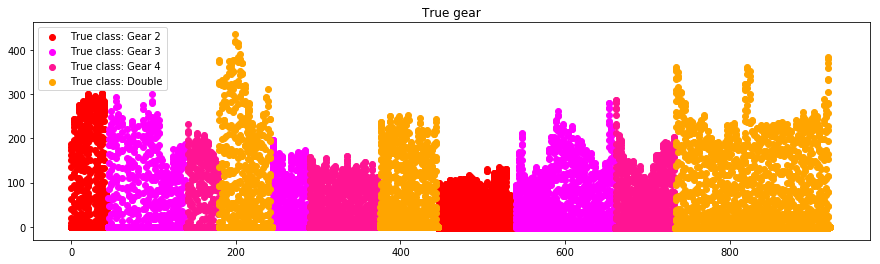

In [18]:
true_Y = np.argmax(Y_fold_list_new[0],axis = 1)
figure = plot_skiedata(true_Y,X_Plot,0)

In [20]:
def BLSTM_Two_Dense_26():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Bidirectional(LSTM(26,return_sequences=True))(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def BLSTM_Two_Dense_64():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Bidirectional(LSTM(64,return_sequences=True))(sequence_input)
    x = Dense(140, activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def BLSTM_Two_Dense_126():
    
    sequence_input = Input(shape=(time_step,dim_X-1))
    x = Bidirectional(LSTM(26,return_sequences=True))(sequence_input)
    x = Dense(X.shape[1], activation='relu')(x)
    x = Flatten()(x)
    preds = Dense(nbr_of_classes, activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [21]:
from keras.models import load_model

cros_val_acc = 0

x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[0]]
Y_train_list = [Y_fold_list_new[i] for i in x_list[0]]

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val = X_fold_list_new[0]
Y_val = Y_fold_list_new[0]
model = BLSTM_Two_Dense_64()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
mCp = ModelCheckpoint('BLSTM_1_2_3_New_Preprocessing_fold_' +str(0) +'.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train[:,:,1:], Y_train, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])


model = load_model('BLSTM_1_2_3_New_Preprocessing_fold_' +str(0) +'.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

cros_val_acc = cros_val_acc + acc

Train on 1342 samples, validate on 329 samples
Epoch 1/10
1342/1342 [==============================] - 297s 221ms/step - loss: 0.3483 - acc: 0.8800 - val_loss: 0.2709 - val_acc: 0.9088
Epoch 2/10
1342/1342 [==============================] - 283s 211ms/step - loss: 0.1090 - acc: 0.9702 - val_loss: 0.1728 - val_acc: 0.9392
Epoch 3/10
1342/1342 [==============================] - 279s 208ms/step - loss: 0.0367 - acc: 0.9911 - val_loss: 0.1606 - val_acc: 0.9422
Epoch 4/10
1342/1342 [==============================] - 282s 210ms/step - loss: 0.0146 - acc: 0.9978 - val_loss: 0.1611 - val_acc: 0.9453
Epoch 5/10
1342/1342 [==============================] - 279s 208ms/step - loss: 0.0126 - acc: 0.9970 - val_loss: 0.2653 - val_acc: 0.9392
Epoch 6/10
1342/1342 [==============================] - 276s 205ms/step - loss: 0.0088 - acc: 0.9985 - val_loss: 0.2221 - val_acc: 0.9362
Epoch 7/10
1342/1342 [==============================] - 274s 204ms/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.1915 - val

In [22]:
from keras.models import load_model

x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[1]]
Y_train_list = [Y_fold_list_new[i] for i in x_list[1]]

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val = X_fold_list_new[1]
Y_val = Y_fold_list_new[1]
model = BLSTM_Two_Dense_64()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
mCp = ModelCheckpoint('BLSTM_1_2_3_New_Preprocessing_fold_' +str(1) +'.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train[:,:,1:], Y_train, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])


model = load_model('BLSTM_1_2_3_New_Preprocessing_fold_' +str(1) +'.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

cros_val_acc = cros_val_acc + acc

Train on 1342 samples, validate on 329 samples
Epoch 1/10
1342/1342 [==============================] - 287s 214ms/step - loss: 0.3533 - acc: 0.8756 - val_loss: 0.3545 - val_acc: 0.8511
Epoch 2/10
1342/1342 [==============================] - 283s 211ms/step - loss: 0.1127 - acc: 0.9657 - val_loss: 0.2495 - val_acc: 0.9149
Epoch 3/10
1342/1342 [==============================] - 283s 211ms/step - loss: 0.0563 - acc: 0.9836 - val_loss: 0.2103 - val_acc: 0.9058
Epoch 4/10
1342/1342 [==============================] - 282s 210ms/step - loss: 0.0317 - acc: 0.9918 - val_loss: 0.1483 - val_acc: 0.9514
Epoch 5/10
1342/1342 [==============================] - 283s 211ms/step - loss: 0.0179 - acc: 0.9963 - val_loss: 0.3471 - val_acc: 0.8480
Epoch 6/10
1342/1342 [==============================] - 282s 210ms/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.1735 - val_acc: 0.9271
Epoch 7/10
1342/1342 [==============================] - 274s 205ms/step - loss: 0.0042 - acc: 0.9985 - val_loss: 0.4991 - val

In [23]:
from keras.models import load_model
fold = 2
x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[fold]]
Y_train_list = [Y_fold_list_new[i] for i in x_list[fold]]

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val = X_fold_list_new[fold]
Y_val = Y_fold_list_new[fold]
model = BLSTM_Two_Dense_64()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
mCp = ModelCheckpoint('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train[:,:,1:], Y_train, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])


model = load_model('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

cros_val_acc = cros_val_acc + acc

Train on 1342 samples, validate on 329 samples
Epoch 1/10
1342/1342 [==============================] - 289s 215ms/step - loss: 0.3483 - acc: 0.8741 - val_loss: 0.2010 - val_acc: 0.9331
Epoch 2/10
1342/1342 [==============================] - 290s 216ms/step - loss: 0.0901 - acc: 0.9739 - val_loss: 0.2032 - val_acc: 0.9240
Epoch 3/10
1342/1342 [==============================] - 291s 217ms/step - loss: 0.0348 - acc: 0.9933 - val_loss: 0.3474 - val_acc: 0.8784
Epoch 4/10
1342/1342 [==============================] - 312s 232ms/step - loss: 0.0217 - acc: 0.9955 - val_loss: 0.2197 - val_acc: 0.9179
Epoch 5/10
1342/1342 [==============================] - 310s 231ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.2331 - val_acc: 0.9240
Epoch 6/10
1342/1342 [==============================] - 303s 226ms/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.1937 - val_acc: 0.9331
Epoch 7/10
1342/1342 [==============================] - 303s 226ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.2150 - val

In [24]:
from keras.models import load_model
fold = 3
x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[fold]]
Y_train_list = [Y_fold_list_new[i] for i in x_list[fold]]

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val = X_fold_list_new[fold]
Y_val = Y_fold_list_new[fold]
model = BLSTM_Two_Dense_64()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
mCp = ModelCheckpoint('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train[:,:,1:], Y_train, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])


model = load_model('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

cros_val_acc = cros_val_acc + acc

Train on 1342 samples, validate on 329 samples
Epoch 1/10
1342/1342 [==============================] - 305s 227ms/step - loss: 0.3616 - acc: 0.8703 - val_loss: 0.1568 - val_acc: 0.9514
Epoch 2/10
1342/1342 [==============================] - 295s 220ms/step - loss: 0.0969 - acc: 0.9709 - val_loss: 0.1306 - val_acc: 0.9544
Epoch 3/10
1342/1342 [==============================] - 313s 233ms/step - loss: 0.0521 - acc: 0.9844 - val_loss: 0.0829 - val_acc: 0.9666
Epoch 4/10
1342/1342 [==============================] - 312s 232ms/step - loss: 0.0196 - acc: 0.9970 - val_loss: 0.0649 - val_acc: 0.9787
Epoch 5/10
1342/1342 [==============================] - 305s 227ms/step - loss: 0.0217 - acc: 0.9925 - val_loss: 0.1207 - val_acc: 0.9544
Epoch 6/10
1342/1342 [==============================] - 294s 219ms/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0481 - val_acc: 0.9757
Epoch 7/10
1342/1342 [==============================] - 289s 216ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0539 - val

In [25]:
from keras.models import load_model
fold = 4
x_list = [[1,2,3,4],[0,2,3,4],[0,1,3,4],[0,1,2,4],[0,1,2,3]]
X_train_list = [X_fold_list_new[i] for i in x_list[fold]]
Y_train_list = [Y_fold_list_new[i] for i in x_list[fold]]

X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_val = X_fold_list_new[fold]
Y_val = Y_fold_list_new[fold]
model = BLSTM_Two_Dense_64()
eS = EarlyStopping(monitor='acc', min_delta=0.00001, patience=3)
mCp = ModelCheckpoint('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train[:,:,1:], Y_train, epochs=10, batch_size=1, validation_data=(X_val[:,:,1:],Y_val),shuffle = True,callbacks = [eS,mCp])


model = load_model('BLSTM_1_2_3_New_Preprocessing_fold_' +str(fold) +'.h5')
predY = model.predict(X_val[:,:,1:])
print(predY.shape)
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_val,axis = 1)
acc = accuracy_score(true_Y,pred_Y)
print("Accuracy: %.2f" % acc)

cros_val_acc = cros_val_acc + acc

Train on 1316 samples, validate on 355 samples
Epoch 1/10
1316/1316 [==============================] - 318s 241ms/step - loss: 0.3709 - acc: 0.8556 - val_loss: 0.2715 - val_acc: 0.9183
Epoch 2/10
1316/1316 [==============================] - 307s 234ms/step - loss: 0.0787 - acc: 0.9772 - val_loss: 0.2746 - val_acc: 0.9155
Epoch 3/10
1316/1316 [==============================] - 301s 229ms/step - loss: 0.0329 - acc: 0.9924 - val_loss: 0.2250 - val_acc: 0.9296
Epoch 4/10
1316/1316 [==============================] - 287s 218ms/step - loss: 0.0138 - acc: 0.9977 - val_loss: 0.2407 - val_acc: 0.9380
Epoch 5/10
1316/1316 [==============================] - 283s 215ms/step - loss: 0.0090 - acc: 0.9985 - val_loss: 0.3117 - val_acc: 0.9239
Epoch 6/10
1316/1316 [==============================] - 292s 222ms/step - loss: 0.0046 - acc: 0.9992 - val_loss: 0.3055 - val_acc: 0.9465
Epoch 7/10
1316/1316 [==============================] - 295s 224ms/step - loss: 0.0047 - acc: 0.9992 - val_loss: 0.2978 - val

In [26]:
c = cros_val_acc/5
print("Accuracy: %.2f" % c)

Accuracy: 0.95


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 140, 16)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 140, 128)          41472     
_________________________________________________________________
dense_9 (Dense)              (None, 140, 140)          18060     
_________________________________________________________________
flatten_5 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 78404     
Total params: 137,936
Trainable params: 137,936
Non-trainable params: 0
_________________________________________________________________
